<center>

# Discrete Event Systems

## Home Assignment 1

### Synchronization and Reachability Analysis

- - -

# Introduction

The objective of this home assignment is to get a deeper understanding of some basic features of discrete event systems. This will be achieved by implementing a few key functions in Python, including the computation of coreachable states, as well as the synchronous composition of two automata. These functions are then applied to the analysis of a simple coordination control system.

This home assignment is performed in *two member groups*. Write all your answers into this notebook and **submit only this notebook (.ipynb) on Canvas**

## Comments and Recommendations

* As before, the following resources will be of great help to you for this assignment:
 * [Python docs](https://docs.python.org/3/)
 * [Google](https://www.google.com)
 * [Wikipedia overview of syntax and semantics](https://en.wikipedia.org/wiki/Python_syntax_and_semantics) 
* We will work extensively with **sets** in this assignment: 
 * A set is created either through `set(*iterable*)` or by listing its elements between curly braces `{*iterable*}`; 
 * An empty set must be created by `set()`. `{}` will create an empty dictionary; 
 * You will also see often something like `{elem for elem in items if elem}`. This is called a *set comprehension* and builds efficiently a new set by iterating over `items` and adding the `elem` for which the if-statement is true; 
 * Have an extensive look at [the set documentation](https://docs.python.org/3/library/stdtypes.html#set) for more information on set methods.  
* The assignment is written for Python 3.5 or later.
* If your code passes all the tests in this notebook, you are on a good way. That does not mean you have passed though! **We will test your code with additional edge cases.** So, convince yourself that everything is correct before you submit.

- - -

# Data Structures

As in Assignment 0, we define the Transition and Automaton classes. They are structured the same as previously. We have included, however, a few validation methods that ensure that the Automaton is consistent at all time. You do not need to change anything here, but give it a thorough read anyway.  

In [32]:
from collections import namedtuple

from util import plot_automaton


Transition = namedtuple(typename='Transition', field_names=[
                        'source', 'event', 'target'])


class Automaton(object):

    def __init__(self, states, init, events, trans, marked=None, forbidden=None):
        """
        This is the constructor of the automaton.

        At creation, the automaton gets the following attributes assigned:
        :param states: A set of states
        :param init: The initial state
        :param events: A set of events
        :param trans: A set of transitions
        :param marked: (Optional) A set of marked states
        :param forbidden: (Optional) A set of forbidden states
        """
        self.states = states
        self.init = init
        self.events = events
        self.trans = trans
        self.marked = marked if marked else set()
        self.forbidden = forbidden if forbidden else set()

    def __str__(self):
        """
        Prints the automaton in a pretty way.
        """
        return 'states: \n\t{}\n' \
               'init: \n\t{}\n' \
               'events: \n\t{}\n' \
               'transitions: \n\t{}\n' \
               'marked: \n\t{}\n' \
               'forbidden: \n\t{}\n'.format(
                   self.states, self.init, self.events,
                   '\n\t'.join([str(t) for t in self.trans]), self.marked, self.forbidden)

    def __setattr__(self, name, value):
        """Validates and protects the attributes of the automaton"""
        if name in ('states', 'events'):
            value = frozenset(self._validate_set(value))
        elif name is 'init':
            value = self._validate_init(value)
        elif name is 'trans':
            value = frozenset(self._validate_transitions(value))
        elif name in ('marked', 'forbidden'):
            value = frozenset(self._validate_subset(value))
        super(Automaton, self).__setattr__(name, value)

    def __getattribute__(self, name):
        """Returns a regular set of the accessed attribute"""
        if name in ('states', 'events', 'trans', 'marked', 'forbidden'):
            return set(super(Automaton, self).__getattribute__(name))
        else:
            return super(Automaton, self).__getattribute__(name)

    def __eq__(self, other):
        """Checks if two Automata are the same"""
        if type(other) is type(self):
            return self.__dict__ == other.__dict__
        return False

    @staticmethod
    def _validate_set(states):
        """Checks that states is a set and the states in it are strings or integers"""
        assert isinstance(states, set)
        for state in states:
            assert isinstance(state, str) or isinstance(
                state, int), 'A state must be either of type string or integer!'
        return states

    def _validate_subset(self, subset):
        """Validates the set and checks whether the states in the subset are part of the state set"""
        subset = self._validate_set(subset)
        assert subset.issubset(
            self.states), 'Marked and forbidden states must be subsets of all states!'
        return subset

    def _validate_init(self, state):
        """Checks whether the state is part of the state set"""
        assert isinstance(state, str) or isinstance(
            state, int), 'The initial state must be of type string or integer!'
        assert state in self.states, 'The initial state must be member of states!'
        return state

    def _validate_transitions(self, transitions):
        """Checks that all transition elements are part in the respective sets (states, events)"""
        assert isinstance(transitions, set)
        for transition in transitions:
            assert isinstance(transition, Transition)
            assert transition.source in self.states
            assert transition.event in self.events
            assert transition.target in self.states
        return transitions

- - -

# Task 1

## Task 1.1 - Reachability v.1 ***[1p]***

To start with, we revisit a few of the functions that you have implemented already in the previous assignment. Whereas Assignment 0 was intended to provide you with a test bench for programming in Python and developing algorithmic understanding, this task is to ensure that you got a correct implementation of `reach` for the rest of the assignment. You might be able to copy your previous solution here. 

A simple reachability algorithm based on set logic is as follows:

**Algorithm 1.** Reachability($\delta, Q_0$)

>**let** $k:=0$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q^+ \mid \exists q \in Q_{k-1} \wedge \delta(q,\sigma) = q^+ \}$
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

This is a so called fix point operation.


Here are some helper functions that might help you with your implementation of the algorithm in code.


In [3]:
def filter_trans_by_source(trans, states_to_keep):
    """Returns a new set containing all transitions where the source is in states_to_keep"""
    return {t for t in trans if t.source in states_to_keep}

def filter_trans_by_events(trans, events_to_keep):
    """Returns a new set containing all transitions where the event is in events_to_keep"""
    return {t for t in trans if t.event in events_to_keep}

def filter_trans_by_target(trans, states_to_keep):
    """Returns a new set containing all transitions where the target is in states_to_keep"""
    return {t for t in trans if t.target in states_to_keep}

def extract_elems_from_trans(trans, field):
    """ 
    Returns a new set with just the elements in a field of all transitions. 
    E.g. field='source' for all source states 
    or field='event' or field='target'
    """
    return {getattr(t, field) for t in trans}

def flip_trans(trans):
    """ Flips the direction of the transitions in the set"""
    return {Transition(t.target, t.event, t.source) for t in trans}

In [146]:
# Now implement the function in code
def reach(trans, start_states):
    """
    Returns the forward reachable states of a transition set
    
    :param trans: set of transitions
    :param start_states: set of states
    """
    # Initializing the reachable states as our starting states
    reach_states = start_states
    
    # Initialize loop boolean
    done = False
    
    # Setting sources to filter transitions from as the start states
    sources = start_states

    while not done:
        # Boolean to check if any new states have been found
        new_state = False
        # Finding all transitions that have our source and extracting the targets
        temp_transitions = filter_trans_by_source(trans, sources)
        targets = extract_elems_from_trans(temp_transitions,'target')
        
        # adding all targets to reach_states who are not already there
        for target in targets: 
            if target not in reach_states:
                reach_states.add(target)
                new_state = True
            
        # Setting the targets as the sources for the next iteration
        sources = targets
        
        # Check if no transitions were found or if no new states are found from our current state
        if not bool(temp_transitions) or not new_state:
            done = True 

    return reach_states

As before, the below is a test cell. You can execute it to test your function with different inputs. The **assert** statements make sure that your function returns the expected results. We encourage you to add also your own tests.

In [147]:
# Space for your own tests

In [148]:
# Single state
assert reach(set(), {1}) == {1}
assert reach({Transition(1, 'a', 1)}, {1}) == {1}

# Simple automata
assert reach({Transition(1, 'a', 2)}, {1}) == {1, 2}
assert reach({Transition(2, 'a', 1)}, {1}) == {1}
assert reach({Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}) == {1, 2}

# Parallel transitions
assert reach({Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}) == {1, 2}
assert reach({Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}) == {1}

# Larger automata
assert reach({Transition(1, 'a', 2), Transition(2, 'a', 3),
              Transition(3, 'a', 1)}, {1}) == {1, 2, 3}

## Task 1.2 - Coreachability ***[1p]***

Similarly, the set of backwards reachable states is defined as:

**Algorithm 2.** BackwardReachability($\delta, Q_0$)

>**let** $k:=0$
>
>**repeat**
>
>>$k := k+1$
>>
>>$Q_k := Q_{k-1} \cup \{q \mid \delta(q,\sigma) \in Q_{k-1} \}$
>>
>**until** $Q_k = Q_{k-1}$
>
**return** $Q_k$

* Implement Algorithm 2.

In [8]:
def coreach(trans, start_states):
    """
    Returns the coreachable (backward reachable) states of a transition set
    
    :param trans: set of transitions
    :param start_states: set of states
    """
    # Initializing the reachable states as our starting states
    coreach_states = start_states

    # Initialize loop boolean
    done = False

    # Setting targets to filter transitions from as the start states
    targets = start_states

    while not done:
        # Boolean to check if any new states have been found
        new_state = False
        
        # Finding all transitions that have our targets and extracting the sources
        temp_transitions = filter_trans_by_target(trans, targets)
        sources = extract_elems_from_trans(temp_transitions,'source')

        # adding all sources to coreach_states who are not already there
        for source in sources: 
            if source not in coreach_states:
                coreach_states.add(source)
                new_state = True
        # Setting the sources as the targets for the next iteration
        targets = sources

        # Check if no transitions were found or if no new states are found from our current state
        if not bool(temp_transitions) or not new_state:
            done = True 

    return coreach_states

In [9]:
# Space for your own tests

In [10]:
# Single state
assert coreach(set(), {1}) == {1}
assert coreach({Transition(1, 'a', 1)}, {1}) == {1}

# Simple automata
assert coreach({Transition(1, 'a', 2)}, {1}) == {1}
assert coreach({Transition(2, 'a', 1)}, {1}) == {1, 2}
assert coreach({Transition(2, 'a', 1), Transition(1, 'a', 2)}, {1}) == {1, 2}

# Parallel transitions
assert coreach({Transition(1, 'a', 2), Transition(1, 'b', 2)}, {1}) == {1}
assert coreach({Transition(2, 'a', 1), Transition(2, 'b', 1)}, {1}) == {1, 2}

# Larger automata
assert coreach({Transition(1, 'a', 2), Transition(2, 'a', 3),
                Transition(3, 'a', 1)}, {1}) == {1, 2, 3}

## Task 1.3 - Synchronous composition ***[1p]***
* Implement the synchronous composition of two automaton. Exclude all unreachble states in the result.

* *Note:* The synchronization function can be implemented in different ways. We suggest to loop through all events, taking common and individual events for the two automata into account. In this event loop appropriate states are merged together according to the basic definition. A number of unreachable states will then be included.   
* *Note:* The synchronized function shall include the complete automaton, including any marked and forbidden states of the synchronized automaton.

Here are again some helper functions that might help you with your implementation of the algorithm in code.

In [11]:
def merge_label(label1, label2):
    """Creates a new label based on two labels"""
    return '{}.{}'.format(label1, label2)

def cross_product(setA, setB):
    """Computes the crossproduct of two sets"""
    return {merge_label(a, b) for b in setB for a in setA}

In [176]:
def synch(aut1, aut2):
    """
    Returns the synchronous composition of two automata.
    
    :param aut1: Automaton
    :param aut2: Automaton
    """

    transitions = set()
    marked_states = set()
    forbidden_states = set()
    
    done = False
    for state_1 in aut1.states:
        for state_2 in aut2.states:
            # Checking if current state will be a marked state
            if ((state_1 in aut1.marked) or (state_2 in aut2.marked)):
                marked_states.add(merge_label(state_1,state_2))
            # Checking if current state will be a forbidden state
            if ((state_1 in aut1.forbidden) or (state_2 in aut2.forbidden)):
                forbidden_states.add(merge_label(state_1,state_2))

            # Extract transitions available from current states
            aut1_transitions = filter_trans_by_source(aut1.trans,{state_1})
            aut2_transitions = filter_trans_by_source(aut2.trans,{state_2})

            # Find all common events from current states
            common_events = {event for event in extract_elems_from_trans(aut1_transitions,'event') 
                             if event in extract_elems_from_trans(aut2_transitions,'event')}
            
            # Since we don't want to add a frozenset, we have to add the transitions one by one. Set comprehension didn't 
            #work since I effectively added a set in a set which is not possible. Another way to to it?
            # Looping trough all transitions, adding the ones which are not a common event and not in the 
            # Language of the other automata
            for transition in aut1_transitions:
                if ((transition.event not in common_events) and (transition.event not in aut2.events)):
                    transitions.add(Transition(merge_label(state_1,state_2),transition.event, 
                                            merge_label(transition.target,state_2)))

            for transition in aut2_transitions:
                if ((transition.event not in common_events) and (transition.event not in aut1.events)):
                    transitions.add(Transition(merge_label(state_1,state_2),transition.event, 
                                            merge_label(state_1, transition.target))) 
                    
            # Adding the common event transitions
            for event in common_events:
                # Since only 1 event from each automata can occur at a given state, we know the set will only contain 1
                # transition, which we extract with the pop function
                aut1_common_transition = filter_trans_by_events(aut1_transitions,{event}).pop()
                aut2_common_transition = filter_trans_by_events(aut2_transitions,{event}).pop()
                
                # Adding the transition
                transitions.add(Transition(merge_label(state_1,state_2),event,
                                        merge_label(aut1_common_transition.target,aut2_common_transition.target)))

    init = merge_label(aut1.init,aut2.init)
    reach_states = reach(transitions,{init})
    
    reach_transitions = {transition for transition in transitions if transition.source in reach_states}
    
    aut1aut2 = Automaton(states=reach_states,
                        init=init,
                        events=aut1.events.union(aut2.events),
                        trans=reach_transitions,
                        marked=marked_states.intersection(reach_states),
                        forbidden=forbidden_states.intersection(reach_states))
    return aut1aut2

# Test the synch function with 2 automata
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd', 'e'},
               init='c',
               events={1, 2},
               trans={Transition('c', 1, 'd'), Transition('d', 2, 'e'), Transition('e', 1, 'c')})
b1b2 = synch(b1, b2)

In [ ]:
# Space for your own tests

In [177]:
# Two 1-state automata
a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set())
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 1.1
assert a1a2.init == '1.2'  # TC - 1.2
assert a1a2.events == set()  # TC - 1.3
assert a1a2.trans == set()  # TC - 1.4

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               marked={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 2.1
assert a1a2.init == '1.2'  # TC - 2.2
assert a1a2.events == set()  # TC - 2.3
assert a1a2.trans == set()  # TC - 2.4
assert a1a2.marked == {'1.2'}  # TC - 2.5

a1 = Automaton(states={1},
               init=1,
               events=set(),
               trans=set(),
               forbidden={1})
a2 = Automaton(states={2},
               init=2,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.2'}  # TC - 3.1
assert a1a2.init == '1.2'  # TC - 3.2
assert a1a2.events == set()  # TC - 3.3
assert a1a2.trans == set()  # TC - 3.4
assert a1a2.forbidden == {'1.2'}  # TC - 3.5

# 2-state automaton and 1-state automaton
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 4.1
assert a1a2.init == '1.3'  # TC - 4.2
assert a1a2.events == {'a'}  # TC - 4.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 4.4
assert a1a2.marked == {'2.3'}  # TC - 4.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3},
               init=3,
               events=set(),
               trans=set())
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 5.1
assert a1a2.init == '1.3'  # TC - 5.2
assert a1a2.events == {'a'}  # TC - 5.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 5.5
assert a1a2.forbidden == {'2.3'}  # TC - 5.6

# Two 2-state automata
a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 6.1
assert a1a2.init == '1.3'  # TC - 6.2
assert a1a2.events == {'a', 'b'}  # TC - 6.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC -6.4
assert a1a2.marked == {'2.3', '2.4'}  # TC - 6.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'a'},
               trans={Transition(3, 'a', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.4'}  # TC - 7.1
assert a1a2.init == '1.3'  # TC - 7.2
assert a1a2.events == {'a'}  # TC - 7.3
assert a1a2.trans == {Transition('1.3', 'a', '2.4')}  # TC - 7.4
assert a1a2.marked == {'2.4'}  # TC - 7.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a'},
               trans={Transition(1, 'a', 2)},
               forbidden={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)},
               forbidden={4})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3', '1.4', '2.4'}  # TC - 8.1
assert a1a2.init == '1.3'  # TC - 8.2
assert a1a2.events == {'a', 'b'}  # TC - 8.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3'), Transition(
    '1.4', 'a', '2.4'), Transition('1.3', 'b', '1.4'), Transition('2.3', 'b', '2.4')}  # TC - 8.4
assert a1a2.forbidden == {'2.3', '1.4', '2.4'}  # TC - 8.5

a1 = Automaton(states={1, 2},
               init=1,
               events={'a', 'b'},
               trans={Transition(1, 'a', 2)},
               marked={2})
a2 = Automaton(states={3, 4},
               init=3,
               events={'b'},
               trans={Transition(3, 'b', 4)})
a1a2 = synch(a1, a2)
assert a1a2.states == {'1.3', '2.3'}  # TC - 9.1
assert a1a2.init == '1.3'  # TC - 9.2
assert a1a2.events == {'a', 'b'}  # TC - 9.3
assert a1a2.trans == {Transition('1.3', 'a', '2.3')}  # TC - 9.4
assert a1a2.marked == {'2.3'}  # TC - 9.5

# Different symbols
b1 = Automaton(states={'a', 'b'},
               init='a',
               events={1, 2},
               trans={Transition('a', 1, 'b')},
               marked={'b'})
b2 = Automaton(states={'c', 'd'},
               init='c',
               events={2},
               trans={Transition('c', 2, 'd')})
b1b2 = synch(b1, b2)
assert b1b2.states == {
    'a.c', 'b.c'}, 'Different symbols should not cause error!'
assert b1b2.init == 'a.c', 'Different symbols should not cause error!'
assert b1b2.events == {1, 2}, 'Different symbols should not cause error!'
assert b1b2.trans == {Transition(
    'a.c', 1, 'b.c')}, 'Different symbols should not cause error!'
assert b1b2.marked == {'b.c'}, 'Different symbols should not cause error!'

- - -

# Task 2

Consider the following two plant models given by the formal languages

<center>
    $L(P_1) = \overline{(ab)^*} \\
    L(P_2) = \overline{(c(d+e))^*}$

and the marked specification languages 

<center>
    $L_m(Sp_1) = (bc)^* \\
    L_m(Sp_2) = (cd)^*$
    
and the synchronised system

<center>
    $S = P_1 \parallel P_2 \parallel Sp_1 \parallel Sp_2$
    
The plant models are already given as automaton ***p1*** and ***p2*** below.

In [181]:
p1 = Automaton(states={'p11', 'p12'},
               init='p11',
               events={'a', 'b'},
               trans={Transition('p11', 'a', 'p12'),
                      Transition('p12', 'b', 'p11')})
p2 = Automaton(states={'p21', 'p22'},
               init='p21',
               events={'c', 'd', 'e'},
               trans={Transition('p21', 'c', 'p22'),
                      Transition('p22', 'd', 'p21'),
                      Transition('p22', 'e', 'p21')})

## Task 2.1 - Petri Net

* Formulate a Petri net for the synchronized system *S* ***[1p]*** 
* and generate the corresponding reachability graph. ***[1p]***
* *Note:* It might be easier to first draw those with a pen on paper and then transfer it into the notebook.

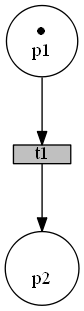

In [203]:
from util import plot_petrinet

PetriNet = namedtuple(typename='PetriNet', field_names=['places', 'transitions', 'arcs'])
Place = namedtuple('Place', ['label', 'marking'])
Arc = namedtuple('Arc', ['source', 'target', 'weight'])

# You can use the plotting function to plot your petri net for S
example = PetriNet(places={Place('p1', 1), Place('p2', 0)},
                   transitions={'t1'},
                   arcs={Arc('p1', 't1', 1), Arc('t1', 'p2', 1)})
plot_petrinet(example, 'example')

In [221]:
def make_synchronized_petri_net_S():
    """
    A little helper function to create the Petri net of S.
    
    You can just hard code the elements of the net just like in the example above.
    We will call this function later in the tests.
    """
    S = PetriNet(places={Place('p11', 1), Place('p12', 0), Place('p21', 1), Place('p22', 0),
                         Place('sp11', 1), Place('sp12', 0), Place('sp21', 1), Place('sp22', 0)},
                   transitions={'a','b','c','d','e'},
                   arcs={Arc('p11', 'a', 1), Arc('a', 'p12', 1), Arc('p12', 'b', 1), Arc('b','p11', 1),
                         Arc('sp11', 'b', 1), Arc('b', 'sp12', 1), Arc('sp12', 'c', 1), Arc('c', 'sp11', 1),
                         Arc('sp21', 'c', 1), Arc('c', 'sp22', 1), Arc('sp22', 'd', 1), Arc('d', 'sp21', 1),
                         Arc('p21', 'c', 1), Arc('c', 'p22', 1), Arc('p22', 'd', 1), Arc('d', 'p21', 1),
                         Arc('p22', 'e', 1), Arc('e', 'p21', 1)})

    return S

plot_petrinet(make_synchronized_petri_net_S(), 'S_petrinet')
len(S.transitions)

5

In [220]:
S = make_synchronized_petri_net_S()
assert isinstance(S, PetriNet)
assert isinstance(S.places.pop(), Place)
assert isinstance(S.arcs.pop(), Arc)

Similarly, we create the reachability graph.

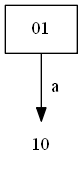

In [223]:
from util import plot_digraph

DiGraph = namedtuple(typename='DiGraph', field_names=['nodes', 'init', 'edges'])
Edge = namedtuple('Edge', ['source', 'target', 'label'])

# You can use the plotting function to plot your reachability graph for S
example = DiGraph(nodes={'01', '10'},
                  init='01',
                  edges={Edge('01', '10', 'a')})
plot_digraph(example, 'example')

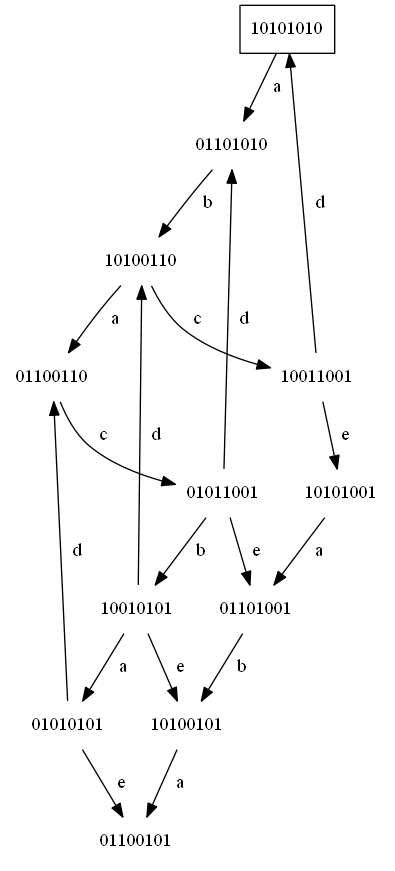

In [231]:
def make_reachability_graph():
    """
    A little helper function to create the reachability graph of S.
    
    You can just hard code the elements of the graph just like in the example above.
    We will call this function later in the tests.
    
    ---- FORMAT: \[P11 P12 P21 P22 SP11 SP12 SP21 SP22]
    """
    # YOUR CODE HERE
    G = DiGraph(nodes={'10101010', '01101010', '10100110', '10011001','01100110','01011001','10101001','10010101',
                       '01101001','01010101','10100101','01100101'},
                  init='10101010',
                  edges={Edge('10101010', '01101010', 'a'),
                         Edge('01101010', '10100110', 'b'),
                         Edge('10100110', '01100110', 'a'),
                         Edge('10100110', '10011001', 'c'),
                         Edge('01100110', '01011001', 'c'),
                         Edge('10011001', '10101001', 'e'),
                         Edge('01011001', '10010101', 'b'),
                         Edge('01011001', '01101001', 'e'),
                         Edge('10101001', '01101001', 'a'),
                         Edge('10010101', '01010101', 'a'),
                         Edge('10010101', '10100101', 'e'),
                         Edge('01101001', '10100101', 'b'),
                         Edge('01010101', '01100101', 'e'),
                         Edge('10100101', '01100101', 'a'),
                         Edge('10011001', '10101010', 'd'),
                         Edge('01010101', '01100110', 'd'),
                         Edge('10010101', '10100110', 'd'),
                         Edge('01011001', '01101010', 'd')})    
    return G

plot_digraph(make_reachability_graph(), 'S_reach_graph')

In [232]:
G = make_reachability_graph()
assert isinstance(G, DiGraph)
assert isinstance(G.nodes, set)
assert all([n.isnumeric() for n in G.nodes])
assert isinstance(G.edges.pop(), Edge)

## Task 2.2 - Synchronized Automaton

* Generate the automaton for the synchronized system *S* by the implemented functions `synch`, ***[1p]***
* and compare the results with the reachability graph in **2.1**.

In [ ]:
def make_synchronized_automaton_S():
    """
    A little helper function to create the automaton of S.

    Define the automata sp1 and sp2 in here too.
    We will call this function later in the tests.
    """
    # YOUR CODE HERE
    raise NotImplementedError()
    return S

plot_automaton(make_synchronized_automaton_S(), 'P1P2SP1SP2')

In [ ]:
S = make_synchronized_automaton_S()
assert S.init == 'p11.p21.sp11.sp21', 'Please, follow the synchronization order specified in Task 2!'

* Compare the synchronized automaton of *S* to the reachability graph. Write down your conclusions in the cell below. ***[1p]***

YOUR ANSWER HERE

## Task 2.3 - Blocking states

* Calculate the reachable and coreachable states in *S* by the implemented functions `reach` and `coreach`, and identify blocking states (states from where no marked state can be reached). ***[1p]***

In [ ]:
reachable = None
coreachable = None 
blocking = None
# YOUR CODE HERE
raise NotImplementedError()

print('The blocking states are: ', blocking)

In [ ]:
assert reachable is not None
assert coreachable is not None
assert blocking is not None

## Task 2.4 - Modified Spec

* Modify the specifications to avoid the blocking states, and verify that no blocking states are achieved by showing that the reachable and coreachable states of *S* are the same for the modified specifications. ***[1p]***
* Explain your modifications first in natural language. ***[1p]***

YOUR ANSWER HERE

In [ ]:
sp1_new = None

# YOUR CODE HERE
raise NotImplementedError()

plot_automaton(sp1_new, 'SP1_new') 

In [ ]:
sp2_new = None

# YOUR CODE HERE
raise NotImplementedError()

plot_automaton(sp2_new, 'SP2_new') 

In [ ]:
# Now synchronize with the new specifications
S_new = synch(synch(p1, p2), synch(sp1_new, sp2_new))

reachable_new = None
coreachable_new = None 
blocking_new = None
# YOUR CODE HERE
raise NotImplementedError()

print('The blocking states now are: ', blocking_new)
plot_automaton(S_new, 'S_new') 

In [ ]:
assert reachable_new is not None
assert coreachable_new is not None
assert blocking_new is not None


- - -

Congratulations! You have reached the end of the assignment. Now,

* Save the notebook
* Upload the .ipynb file to Canvas
* Enjoy the rest of the day! 